In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd

In [29]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [31]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [33]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [36]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23')

In [37]:
latest_date = '2017-08-23'

last_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [38]:
# Calculate the date 1 year ago from the last data point in the database
yesterday = last_date - timedelta(days=365)

yesterday_str = yesterday.strftime('%Y-%m-%d')

print(yesterday_str)


2016-08-23


In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > yesterday_str).\
    order_by(Measurement.date).all()
results

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

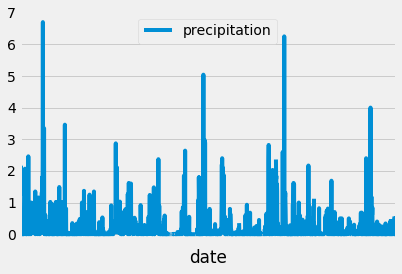

In [41]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df.plot()
plt.xticks([])
plt.savefig('./Images/prcp.png')
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df["precipitation"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [43]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Station.station).count()

station_count

9

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_active_most = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_active[0][0]).all()

station_active_most

[(54.0, 85.0, 71.66378066378067)]

In [45]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#session.query(Measurement.date).order_by(Measurement.date.desc()).first()
session.query(Measurement.date).filter(Measurement.station == station_active[0][0]).order_by(Measurement.date.desc()).first()

('2017-08-18')

In [47]:
latest_date_t = '2017-08-18'

last_date_t = dt.datetime.strptime(latest_date_t, '%Y-%m-%d')

yesterday_t = last_date_t - timedelta(days=365)

yesterday_str_t = yesterday_t.strftime('%Y-%m-%d')

print(yesterday_str_t)


2016-08-18


In [48]:
results_s = session.query(Measurement.tobs).filter(Measurement.date > yesterday_str_t, Measurement.station == station_active[0][0]).order_by(Measurement.tobs.desc()).all()
results_s

[(83.0),
 (82.0),
 (82.0),
 (82.0),
 (81.0),
 (81.0),
 (81.0),
 (81.0),
 (81.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (80.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 (76.0),
 

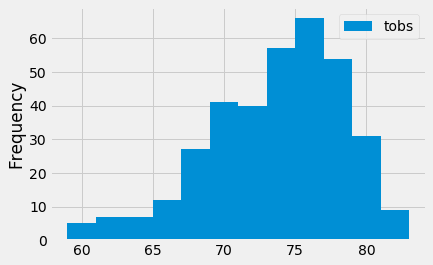

In [49]:
tobs = results_s[0]
df_tobs = pd.DataFrame(results_s, columns=['tobs'])
df_tobs.plot.hist(tobs, bins=12)
plt.ylabel('Frequency')
plt.savefig('./Images/tobs.png')
plt.show()

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.


In [ ]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
